In [1]:
import torchvision
from torchvision import transforms
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import urllib

try:
    from urllib.error import URLError
    from urllib.request import urlretrieve
except ImportError:
    from urllib2 import URLError
    from urllib import urlretrieve
import torch
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.Resize(32),
                                    transforms.CenterCrop(32),
                                    transforms.ToTensor()])

In [3]:

def report_download_progress(chunk_number, chunk_size, file_size):
    if file_size != -1:
        percent = min(1, (chunk_number * chunk_size) / file_size)
        bar = '#' * int(64 * percent)
        sys.stdout.write('\r0% |{:<64}| {}%'.format(bar, int(percent * 100)))


def download(destination_path, url, quiet):
    if os.path.exists(destination_path):
        if not quiet:
            print('{} already exists, skipping ...'.format(destination_path))
    else:
        print('Downloading {} ...'.format(url))
        try:
            hook = None if quiet else report_download_progress
            urlretrieve(url, destination_path, reporthook=hook)
        except URLError:
            raise RuntimeError('Error downloading resource!')
        finally:
            if not quiet:
                # Just a newline.
                print()


def unzip(zipped_path, quiet):
    unzipped_path = os.path.splitext(zipped_path)[0]
    if os.path.exists(unzipped_path):
        if not quiet:
            print('{} already exists, skipping ... '.format(unzipped_path))
        return
    with gzip.open(zipped_path, 'rb') as zipped_file:
        with open(unzipped_path, 'wb') as unzipped_file:
            unzipped_file.write(zipped_file.read())
            if not quiet:
                print('Unzipped {} ...'.format(zipped_path))

In [4]:
# parser = argparse.ArgumentParser(
#         description='Download the CelebA dataset from the internet')
# parser.add_argument(
#         '-d', '--destination', default='.', help='Destination directory')
# parser.add_argument(
#         '-q',
#         '--quiet',
#         action='store_true',
#         help="Don't report about progress")
# options = parser.parse_args()
# options
if not os.path.exists('.'):
    os.makedirs('.')

try:
    path = os.path.join(os.getcwd(), 'celebA')
    url = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'
    download(path, url, 'quiet')
    !unzip {path}
except KeyboardInterrupt:
    print('Interrupted')

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052344.jpg  
  inflating: 

In [5]:
base_dir = 'processed_celeba_small/celeba/'
dataset= torchvision.datasets.ImageFolder(base_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True)

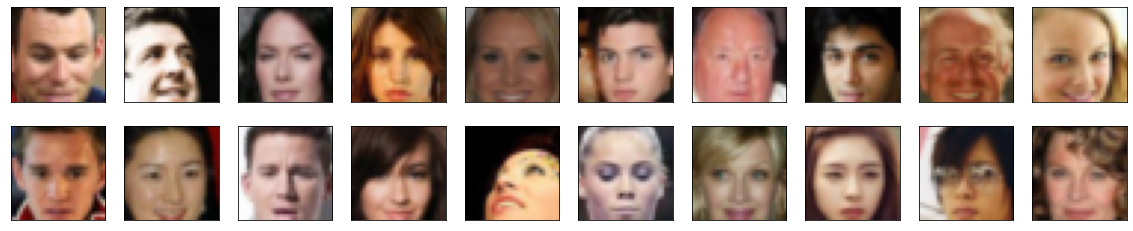

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(dataloader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x *(max-min) + min
    return x

In [8]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9922)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        ## 32x32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)

        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        return x

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, self.conv_dim*4*4*4)

        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, kernel_size=4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, kernel_size=4)
        self.t_conv3 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        # batch_size, depth, 4 * 4
        x = x.view(-1, self.conv_dim*4, 4, 4)

        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = torch.tanh(self.t_conv3(x))
        
        return x

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)

In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [17]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=[0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            # fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            # sum loss and backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss            
            g_optimizer.zero_grad()
             # Train with fake images and flipped labels
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # discriminator loss on fake images
            g_fake = D(fake_images)
            g_loss = real_loss(g_fake)
            g_loss.backward()
            g_optimizer.step()   
                
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [ ]:
n_epochs = 20
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.4982 | g_loss: 0.9464
Epoch [    1/   20] | d_loss: 0.4369 | g_loss: 3.1249
Epoch [    1/   20] | d_loss: 0.9570 | g_loss: 1.7813
Epoch [    1/   20] | d_loss: 0.5253 | g_loss: 2.5911
Epoch [    1/   20] | d_loss: 0.6677 | g_loss: 1.7790
Epoch [    1/   20] | d_loss: 0.6714 | g_loss: 1.9674
Epoch [    1/   20] | d_loss: 0.6911 | g_loss: 2.0148
Epoch [    1/   20] | d_loss: 0.8963 | g_loss: 1.3622
Epoch [    1/   20] | d_loss: 0.9318 | g_loss: 1.2167
Epoch [    2/   20] | d_loss: 0.9761 | g_loss: 1.0990
